## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
#load and read the dataset
df=pd.read_csv('ab_data.csv')
df.head(5)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.tail(5)

,user_id,timestamp,group,landing_page,converted
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0
294477,715931,2017-01-16 12:40:24.467417,treatment,new_page,0


> Calculate the time duration for which this A/B test was carried out

In [4]:
df.timestamp.min()

'2017-01-02 13:42:05.378582'

In [5]:
df.timestamp.max()

'2017-01-24 13:41:54.460509'

> We can see from the difference between max and min values of the timestamp that the A/B test was carried out for a period of 22 days

b. Use the cell below to find the number of rows in the dataset.

In [6]:
#number of rows in the dataset
df.shape[0]

294478

c. The number of unique users in the dataset.

In [7]:
# No of unique users
unique_users= df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [8]:
# No of unique users converted
users_converted=df.query('converted==1').user_id.nunique()
users_converted

35173

In [9]:
#proportion of users converted
prop_converted=users_converted/unique_users
prop_converted

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [10]:
#Number of times the new_page and treatment don't match
No_of_nomatch1=df.query('group=="treatment" & landing_page!="new_page"').shape[0]
No_of_nomatch1

1965

In [11]:
No_of_nomatch2=df.query('group=="control" & landing_page=="new_page"').shape[0]
No_of_nomatch2

1928

In [12]:
No_of_nomatch=No_of_nomatch1 + No_of_nomatch2
No_of_nomatch

3893

f. Do any of the rows have missing values?

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [15]:
#view missing value count
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [16]:
#Remove rows where treatment does not match with new page and control does not match with old page
data_error1=df.query('group=="treatment" & landing_page!="new_page"')
data_error2=df.query('group=="control" & landing_page!="old_page"')
data_error=data_error1.append(data_error2)
df2=df.drop(data_error.index)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [17]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [18]:
unique_user_id=df2.user_id.nunique()
unique_user_id

290584

In [19]:
df2.shape

(290585, 5)

b. There is one **user_id** repeated in **df2**.  What is it?

In [20]:
sum(df2.user_id.duplicated())

1

c. What is the row information for the repeat **user_id**? 

In [21]:
#find the duplicated row
duplicated_bool=df2.duplicated(subset=['user_id'],keep='first') #refer to https://stackoverflow.com/questions/47180983/find-duplicate-rows-in-a-pandas-dataframe
duplicated_rows=df2.loc[duplicated_bool==True]
duplicated_rows

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [22]:
#drop duplicate row
df2=df2.drop_duplicates(subset=['user_id'],keep="first") #https://www.ritchieng.com/pandas-removing-duplicate-rows/
df2.shape

(290584, 5)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [23]:
#conversion probability for both landing_pages
df2.converted.mean()


0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [24]:
#probability for conversion in control group
df2_control_group=df2.query('group=="control"')
prob_conv_control=df2_control_group.converted.mean()
prob_conv_control

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [25]:
#probability for conversion in treatment group
df2_treatment_group=df2.query('group=="treatment"')
prob_conv_treatment=df2_treatment_group.converted.mean()
prob_conv_treatment

0.11880806551510564

d. What is the probability that an individual received the new page?

In [26]:
#probability of individual receiving new page
probability_newpage=df2.query('landing_page=="new_page"').count()/df2.count()
probability_newpage

user_id         0.500062
timestamp       0.500062
group           0.500062
landing_page    0.500062
converted       0.500062
dtype: float64

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

> ### Analysis
>We can see that the probability of an individual receiving the new page is 50%. 
>The probability of conversion for an individual in the control group is 12.04%
>The probability of conversion for an individual in the treatment group is 11.88%
>The probability of conversion for an individual irrespective of the group is 11.96%
>We can see that the probability of conversion in the control group is slightly greater than the probability of conversion in the treatment group but the difference is not substantial enough for us to make any conclusive decisions. We do not have evidence if factors like change aversion and novelty effect have been considered. The time duration for which this A/B test was carried out is 22 days, we also need industry data to understand that if this time period and sample size is enough to make conclusive decisions. 
>Another factor to consider is that what constitutes as a conversion and what is the value of a conversion. If the value of a single conversion is high(assuming  that conversion has monetary value as the website is an e-commerce website) then even a small difference in the probability can translate into a substantial financial gain. In that particular case we can say that the "old_page" is more effective as a landing page.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

> **$H_{0}: p_{new} - p_{old}<=0$**

> **$H_{1}: p_{new} - p_{old}>0$**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [27]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [28]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

>We should note than p_old=p_new

c. What is $n_{new}$, the number of individuals in the treatment group?

In [29]:
n_new=df2.query('group=="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [30]:
n_old=df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [31]:
new_page_converted=np.random.choice([0,1],size=n_new,p=[p_new,1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [32]:
old_page_converted=np.random.choice([0,1],size=n_old,p=[p_old,1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [33]:
new_page_converted.mean()-old_page_converted.mean()

-0.00082358245340086178

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [34]:
p_diffs=[]
for _ in range(10000):
    new_page_converted=np.random.choice([0,1],size=n_new,p=[p_new,1-p_new])
    old_page_converted=np.random.choice([0,1],size=n_old,p=[p_old,1-p_old])
    p_diffs.append(new_page_converted.mean()-old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

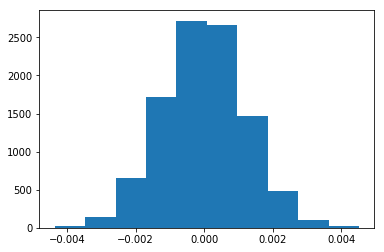

In [35]:
p_diffs=np.array(p_diffs)

#plot sampling distribution
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [36]:
obs_diff=prob_conv_treatment-prob_conv_control
obs_diff

-0.0015782389853555567

In [37]:
p_val=(p_diffs>obs_diff).mean()
p_val

0.90049999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

><ol>
    <li>The value computed in part j is p-value. Since our p-value is close to 0.9005 i.e, it is large and closer to 1 we wouldn't move away from our null hypothesis.</li>
    <li>The definition of a p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null hypothesis is true.</li>
    <li>Now we know that Type 1 Error rate(alpha) is 5% or 0.05. Now since p-value is around 0.9005 it is greater than alpha. P-value needs to be smaller than the threshold for us to choose the alternative. Since p-val is greater than the alpha we fail to reject the null hypothesis. </li>
    <li>To explain further it means that converted rate of new page is less than that of old page.</li>
    
></ol>

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [38]:
import statsmodels.api as sm
convert_old = df2[df2['landing_page'] == "old_page"][df2['converted']==1].shape[0]
convert_new = df2[df2['landing_page'] == "new_page"][df2['converted']==1].shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [39]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],[n_new, n_old], alternative="larger")
z_score, p_value

(-1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The p-value in j and k are very similar and in both cases they are very large compared to the threshold alpha(0.05) hence we fail to reject the null hypothesis. This means that conversion rates for new pages is less than conversion rates for the old pages.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

>Logistic Regression is a regression approach used to predict only two possible outcomes. As in this case there are only two possible outcomes: conversion or no conversion we will be using Logistic Regression in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [40]:
#obtain dummy variables for the group column
df2[[ 'old_page','ab_page']]=pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,old_page,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [41]:
#drop one of the columns 'old_page'
#the column dropped will form the baseline
df2=df2.drop(['old_page'], axis=1)
df2.head(1)

,user_id,timestamp,group,landing_page,converted,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [42]:
from scipy import stats
stats.chisqprob = lambda chisq, df2: stats.chi2.sf(chisq, df2) #https://knowledge.udacity.com/questions/194565

In [43]:
#add an intercept
#fitting a regression model
df2['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sun, 31 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        16:12:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [44]:
#interpret results
np.exp(-0.0150) 

0.98511193960306265

> For the ab_page (new_page), holding all else constant, we can say that the new page is 0.985 times more likely to convert than the old page. Since 0.985 is less than 1 ,holding all else constant we can say that old page is more likely to convert as compared to the new page.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

><ul>
    <li>In logistic regression the linear model predicts the log odds instead of the response itself. </li>
    <li>The p-value associated with the ab_page is 0.19</li>
    <li>The null and alternative hypothesis is different from those in Part II, Hence p-value is different from the value found in Part II. Here the hypotheses are: </li>
    
></ul>

**$H_{0}: p_{new} = p_{old}$**
    
**$H_{1}: p_{new} != p_{old}$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> It is a good idea to add other factors into our regression model because we may need to consider other factors which influence conversion. On the other hand if we add to more variables correlated to each other than this can lead to flipped regression coefficients from the expected relationships. This can lead to overfitting which can then reduce generalizability of the model beyond the data used.

> I have referred to this article to understand the concept better. <a href="https://www.statisticssolutions.com/what-is-logistic-regression/">Logistic Regression</a>

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [45]:
df_countries=pd.read_csv('countries.csv')
df_countries.head(2)

,user_id,country
0,834778,UK
1,928468,US


In [46]:
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
#join the 2 datasets
df3=df_countries.set_index('user_id').join(df2.set_index('user_id')) #https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
df3.head(2)

,country,timestamp,group,landing_page,converted,ab_page,intercept
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1


In [48]:
#obtain dummy variables for the country column
df3[[ 'UK','US','CA']]=pd.get_dummies(df3['country'])
df3.head(2)

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1


In [49]:
#fitting a regression model
# We will drop the 'CA column'
log_mod2 = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US']])
results2 = log_mod2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Sun, 31 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        16:13:06   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
UK            -0.0408      0.027     -1.518      0.129      -0.093       0.012
US             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

> We can see that the p-value for both UK and US is more than the threshold(0.05) hence countries do not have any statistically significant impact on conversions.

In [50]:
#fitting a regression model

log_mod3 = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US','ab_page']])
results3 = log_mod3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sun, 31 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        16:13:11   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
UK            -0.0408      0.027     -1.516      0.130      -0.093       0.012
US             0.0099      0.013      0.743      0.457      -0.016       0.036
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
==============================================================================
"""

> We can see that the countries and ab_page all have p-values greater than 0.05 which is the threshold for type 1 error. Hence we can say that they do not have any statistically significant impact on the conversions.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [51]:
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['US_ab_page'] = df3['US']*df3['ab_page']
df3['CA_ab_page'] = df3['CA']*df3['ab_page']
df3.head(2)             

,country,timestamp,group,landing_page,converted,ab_page,intercept,UK,US,CA,UK_ab_page,US_ab_page,CA_ab_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,0,1,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0,1


In [51]:
#fitting a regression model
# We will drop the CA_ab_page
log_mod4 = sm.Logit(df3['converted'], df3[['intercept','ab_page','UK', 'UK_ab_page','US','US_ab_page']])
results4 = log_mod4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sun, 31 May 2020   Pseudo R-squ.:               3.482e-05
Time:                        15:50:39   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
US            -0.0057      0.019     -0.306      0.760      -0.043       0.031
US_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

> We can see that p-value for the ab_page, the countries and the interactions are all above the threshold value of 0.05. Hence we can say that the interactions between page and country does not have a statistically significant effect on conversion. We can conclude that the old page converts better than the new page based on the data. 

> Hence we fail to reject the null hypothesis based on the data. 

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> I have added all the resources used in the project as comments. Additionally I have used references from the Udacity course material.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [52]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0